##### Import Libraries and Setup

This block sets up your environment with everything needed to load, preprocess, and model your IMU gesture data using a Temporal Convolutional Network (TCN) optimized for Arduino deployment.

In [12]:
# OS and file handling
import os
import zipfile
import shutil

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# TensorFlow core + TCN modeling
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    Dropout, Add, GlobalAveragePooling1D, Dense
)


##### Unzip and Inspect the HGAG-DATA1 Dataset

This code extracts the contents of the uploaded HGAG-DATA1.zip archive into a folder named HGAG-DATA1. The dataset contains accelerometer and gyroscope data organized by gesture → subject → CSV signals.

In [13]:
# Unzip the uploaded dataset
with zipfile.ZipFile("HGAG-DATA1.zip", "r") as zip_ref:
    zip_ref.extractall("HGAG-DATA1")


##### Visualize Folder Structure

This prints the nested folder hierarchy for verification. Each gesture contains multiple subject folders, and inside each subject are 6 CSV files for accel_x/y/z and gyro_x/y/z.

In [14]:
# Function to print full folder tree
def print_full_tree(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = '│   ' * level
        print(f"{indent}📁 {os.path.basename(root)}/")
        for f in files:
            print(f"{indent}    └── 📄 {f}")

# Visualize HGAG folder tree
print("🗂️ Full Folder Tree (HGAG-DATA1):")
print_full_tree("HGAG-DATA1")


🗂️ Full Folder Tree (HGAG-DATA1):
📁 HGAG-DATA1/
│   📁 HGAG-DATA1/
│   │   📁 Clapping/
│   │   │   📁 Subject_6/
│   │   │   │   📁 .csv/
│   │   │   │       └── 📄 accel_x_data.csv
│   │   │   │       └── 📄 accel_y_data.csv
│   │   │   │       └── 📄 gyro_x_data.csv
│   │   │   │       └── 📄 gyro_z_data.csv
│   │   │   │       └── 📄 accel_z_data.csv
│   │   │   │       └── 📄 gyro_y_data.csv
│   │   │   📁 Subject_7/
│   │   │   │   📁 .csv/
│   │   │   │       └── 📄 accel_x_data.csv
│   │   │   │       └── 📄 accel_y_data.csv
│   │   │   │       └── 📄 gyro_x_data.csv
│   │   │   │       └── 📄 gyro_z_data.csv
│   │   │   │       └── 📄 accel_z_data.csv
│   │   │   │       └── 📄 gyro_y_data.csv
│   │   │   📁 Subject_24/
│   │   │   │   📁 .csv/
│   │   │   │       └── 📄 accel_x_data.csv
│   │   │   │       └── 📄 accel_y_data.csv
│   │   │   │       └── 📄 gyro_x_data.csv
│   │   │   │       └── 📄 gyro_z_data.csv
│   │   │   │       └── 📄 accel_z_data.csv
│   │   │   │       └── 📄 gyro_y_data.csv
│

##### Load All Gesture Samples from HGAG-DATA1

Traverses every subject and folder recursively

Reads and aligns the six time-series signals per gesture

Filters out noisy/short recordings

Returns X_raw: a list of time series (timesteps × 6), and y_raw: gesture labels

In [17]:
import os
import pandas as pd

# Define gestures and base path
gestures = ["Clapping", "Fist Making", "Index Thumb Tap", "Thumb Up", "Wrist Extension"]
base_path = "HGAG-DATA1/HGAG-DATA1"

def load_full_dataset(base_path, gestures):
    """
    Recursively loads all CSV samples for all subjects under each gesture.
    
    Args:
        base_path (str): Root directory containing gesture folders.
        gestures (list of str): Names of gesture folders.

    Returns:
        X (list of np.ndarray): Loaded data arrays.
        y (list of str): Corresponding gesture labels.
    """
    X, y = [], []

    for gesture in gestures:
        gesture_path = os.path.join(base_path, gesture)
        if not os.path.isdir(gesture_path):
            print(f"⚠️ Gesture folder not found: {gesture_path}")
            continue

        print(f"📂 Loading {gesture}...")

        for root, dirs, files in os.walk(gesture_path):
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    try:
                        df = pd.read_csv(file_path, header=None)
                        if df.shape[0] >= 30:  # optional: skip too-short sequences
                            X.append(df.values)
                            y.append(gesture)
                    except Exception as e:
                        print(f"❌ Failed to read {file_path}: {e}")

    print(f"✅ Loaded {len(X)} samples.")
    return X, y
                        

In [18]:
# Load data
X_raw, y_raw = load_full_dataset(base_path, gestures)
print(f"✅ Loaded {len(X_raw)} samples.")

📂 Loading Clapping...
📂 Loading Fist Making...
📂 Loading Index Thumb Tap...
📂 Loading Thumb Up...
📂 Loading Wrist Extension...
✅ Loaded 1290 samples.
✅ Loaded 1290 samples.


##### Explore Input Shapes and Sequence Lengths

Displays shapes of a few sequences to confirm data integrity

Prints the minimum, maximum, and average number of timesteps per sample

Visualizes how sequence lengths are distributed across the dataset

Sample 0: Shape = (50, 250), Label = Clapping
Sample 1: Shape = (50, 250), Label = Clapping
Sample 2: Shape = (50, 250), Label = Clapping
📊 Min length: 49
📊 Max length: 50
📊 Avg length: 49


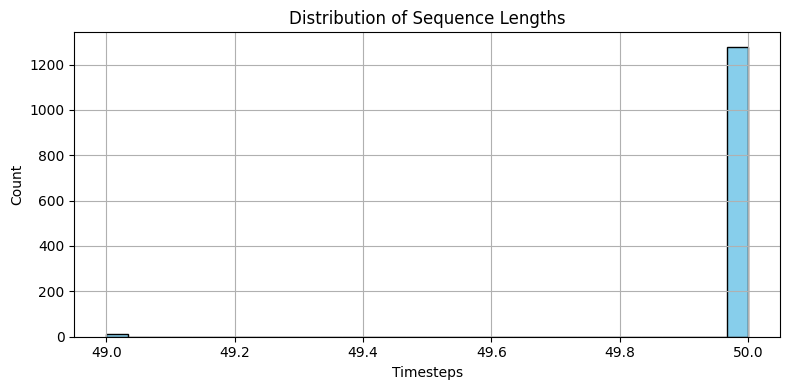

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Show example shapes
for i in range(3):
    print(f"Sample {i}: Shape = {X_raw[i].shape}, Label = {y_raw[i]}")

# Analyze sequence lengths
sequence_lengths = [seq.shape[0] for seq in X_raw]
print("📊 Min length:", min(sequence_lengths))
print("📊 Max length:", max(sequence_lengths))
print("📊 Avg length:", int(np.mean(sequence_lengths)))

# Plot distribution of sequence lengths
plt.figure(figsize=(8, 4))
plt.hist(sequence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Timesteps")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Padding, Normalization, and Label Encoding

Pads all sequences to the same length for batching

Standardizes sensor features across all gestures

One-hot encodes gesture class labels for multi-class classification

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Pad sequences to equal length
sequence_lengths = [seq.shape[0] for seq in X_raw]
maxlen = max(sequence_lengths)
X_padded = pad_sequences(X_raw, padding='post', dtype='float32', maxlen=maxlen)
print("✅ Padded shape:", X_padded.shape)

# Step 2: Normalize all features using StandardScaler
n_samples, n_timesteps, n_features = X_padded.shape
X_reshaped = X_padded.reshape(-1, n_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_features)

# Step 3: Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
y_categorical = to_categorical(y_encoded)

# Final shapes
print("✅ Final data shapes:")
print("X_scaled:", X_scaled.shape)
print("y_categorical:", y_categorical.shape)


✅ Padded shape: (1290, 50, 250)
✅ Final data shapes:
X_scaled: (1290, 50, 250)
y_categorical: (1290, 5)


#### Build an Optimized Temporal Convolutional Network (TCN)

##### Import Dependencies

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout,
    Add, GlobalAveragePooling1D, Dense, Multiply, GlobalMaxPooling1D,
    Reshape, SpatialDropout1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical


Squeeze-and-Excitation (SE) Block

This block dynamically recalibrates channel-wise feature responses, improving the model’s attention on important temporal features.

In [22]:
def squeeze_excite_block(x, ratio=8):
    filters = x.shape[-1]
    se = GlobalAveragePooling1D()(x)
    se = Reshape((1, filters))(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([x, se])


##### Residual Temporal Convolution Block (TCN Block)

Causal convolutions (preserve sequence order)

Dilated convolutions (expand temporal field)

Residual connections

SE attention block

Spatial dropout (regularization for temporal dependencies)

In [23]:
def residual_tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.2):
    shortcut = x

    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)

    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)  # SE block
    x = SpatialDropout1D(dropout_rate)(x)

    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    return Activation('relu')(x)


##### Build the Optimized TCN Model

This stacks several residual TCN blocks with increasing dilation rates to capture short and long-term dependencies.

In [24]:
def build_optimized_tcn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = inputs

    # Larger receptive field using dilation
    for d in [1, 2, 4, 8, 16]:
        x = residual_tcn_block(x, filters=64, kernel_size=3, dilation_rate=d)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


##### Focal Loss Function (instead of CrossEntropy)

This loss helps the model focus on harder, misclassified examples, making it especially powerful for imbalanced or nuanced gesture data.

In [25]:
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=1))
    return loss


##### Compile and Summarize Model

In [27]:
# Replace these with your preprocessed shapes
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = build_optimized_tcn(input_shape, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

model.summary()


W0000 00:00:1744216511.775871 2158430 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 250)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 64)    │     48,064 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 50, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 50, 64)    │          0 │ activation[0][0]  │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 64)    │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 8)      │        520 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 64)     │        576 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 50, 64)    │          0 │ multiply[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 64)    │     16,064 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 64)    │          0 │ spatial_dropout1… │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 50, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 50, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 192,301 (751.18 KB)

 Trainable params: 191,021 (746.18 KB)

 Non-trainable params: 1,280 (5.00 KB)

##### Train the Optimized TCN Model with Callbacks

EarlyStopping: Stop training if no improvement

ModelCheckpoint: Save best weights based on validation accuracy

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_tcn_model.h5", monitor='val_accuracy', save_best_only=True)
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2299 - loss: 0.3133 

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.2302 - loss: 0.3119 - val_accuracy: 0.2984 - val_loss: 0.2528
Epoch 2/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2509 - loss: 0.2624

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.2515 - loss: 0.2618 - val_accuracy: 0.3256 - val_loss: 0.2355
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.3003 - loss: 0.2337 - val_accuracy: 0.3101 - val_loss: 0.2345
Epoch 4/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2934 - loss: 0.2389

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.2937 - loss: 0.2386 - val_accuracy: 0.3450 - val_loss: 0.2257
Epoch 5/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3019 - loss: 0.2236

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.3035 - loss: 0.2233 - val_accuracy: 0.3992 - val_loss: 0.2183
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.3725 - loss: 0.2088 - val_accuracy: 0.3721 - val_loss: 0.2079
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.4338 - loss: 0.1949 - val_accuracy: 0.3992 - val_loss: 0.1994
Epoch 8/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4873 - loss: 0.1700

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4873 - loss: 0.1701 - val_accuracy: 0.4225 - val_loss: 0.1959
Epoch 9/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5436 - loss: 0.1548

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5418 - loss: 0.1551 - val_accuracy: 0.4806 - val_loss: 0.1788
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.4961 - loss: 0.1605 - val_accuracy: 0.4651 - val_loss: 0.1771
Epoch 11/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5114 - loss: 0.1603

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5122 - loss: 0.1598 - val_accuracy: 0.5155 - val_loss: 0.1620
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5314 - loss: 0.1406 - val_accuracy: 0.5078 - val_loss: 0.1664
Epoch 13/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5644 - loss: 0.1363

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.5642 - loss: 0.1365 - val_accuracy: 0.5349 - val_loss: 0.1562
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5675 - loss: 0.1315 - val_accuracy: 0.5310 - val_loss: 0.1573
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5983 - loss: 0.1236 - val_accuracy: 0.5078 - val_loss: 0.1489
Epoch 16/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6065 - loss: 0.1284

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6056 - loss: 0.1283 - val_accuracy: 0.5698 - val_loss: 0.1471
Epoch 17/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6418 - loss: 0.1169

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6410 - loss: 0.1169 - val_accuracy: 0.5814 - val_loss: 0.1473
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6126 - loss: 0.1176 - val_accuracy: 0.5504 - val_loss: 0.1502
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5901 - loss: 0.1227 - val_accuracy: 0.5039 - val_loss: 0.1521
Epoch 20/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6311 - loss: 0.1159

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6313 - loss: 0.1155 - val_accuracy: 0.6047 - val_loss: 0.1489
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6344 - loss: 0.1144 - val_accuracy: 0.5465 - val_loss: 0.1484
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6678 - loss: 0.1042 - val_accuracy: 0.5465 - val_loss: 0.1442
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6019 - loss: 0.1173 - val_accuracy: 0.5465 - val_loss: 0.1462
Epoch 24/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6526 - loss: 0.1059 - val_accuracy: 0.5659 - val_loss: 0.1375
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6785 - loss: 0.0973 - val_accuracy: 0.5930 - val_loss: 0.1453
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6852 - loss: 0.0966 - val_accuracy: 0.5581 - val_loss: 0.1405
Epoch 27/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7041 - loss: 0.0934

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7044 - loss: 0.0933 - val_accuracy: 0.6085 - val_loss: 0.1403
Epoch 28/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7168 - loss: 0.0915

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7165 - loss: 0.0915 - val_accuracy: 0.6279 - val_loss: 0.1352
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7107 - loss: 0.0909 - val_accuracy: 0.6240 - val_loss: 0.1367
Epoch 30/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6962 - loss: 0.0898

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6966 - loss: 0.0900 - val_accuracy: 0.6550 - val_loss: 0.1319
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6996 - loss: 0.0874 - val_accuracy: 0.6357 - val_loss: 0.1295
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7307 - loss: 0.0826 - val_accuracy: 0.5853 - val_loss: 0.1470
Epoch 33/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7170 - loss: 0.0893

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7169 - loss: 0.0892 - val_accuracy: 0.6589 - val_loss: 0.1395
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7257 - loss: 0.0861 - val_accuracy: 0.5853 - val_loss: 0.1557
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7103 - loss: 0.0911 - val_accuracy: 0.6512 - val_loss: 0.1328
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7509 - loss: 0.0806 - val_accuracy: 0.6550 - val_loss: 0.1204
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7436 - loss: 0.0764 - val_accuracy: 0.6395 - val_loss: 0.1304
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7241 - loss: 0.0827 - val_accuracy: 0.6512 - val_loss: 0.1292
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7332 - loss: 0.0765 - val_accuracy: 0.6318 - val_loss: 0.1279
Epoch 40/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7309 - loss: 0.0812 

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7310 - loss: 0.0811 - val_accuracy: 0.6783 - val_loss: 0.1349
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7599 - loss: 0.0725 - val_accuracy: 0.6085 - val_loss: 0.1261
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7634 - loss: 0.0725 - val_accuracy: 0.6705 - val_loss: 0.1295
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7572 - loss: 0.0807 - val_accuracy: 0.6357 - val_loss: 0.1473
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7580 - loss: 0.0720 - val_accuracy: 0.6085 - val_loss: 0.1305
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7656 - loss: 0.0767 - val_accuracy: 0.6512 - val_loss: 0.1219
Epoch 46/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7535 - loss: 0.0708

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7538 - loss: 0.0709 - val_accuracy: 0.6822 - val_loss: 0.1216


##### Plot Training History (Loss and Accuracy)

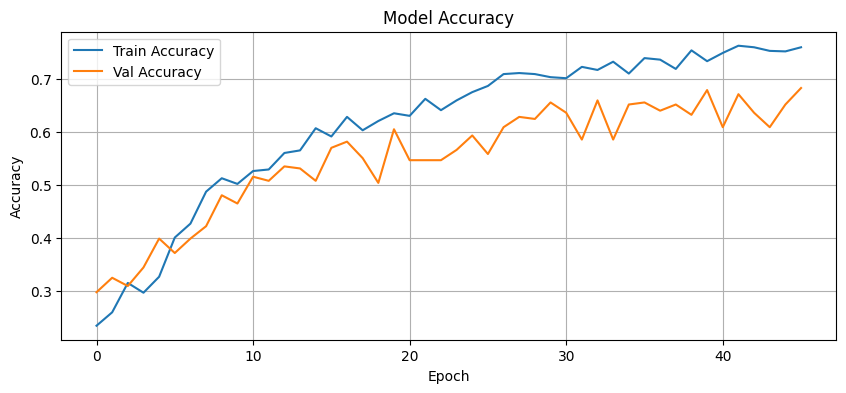

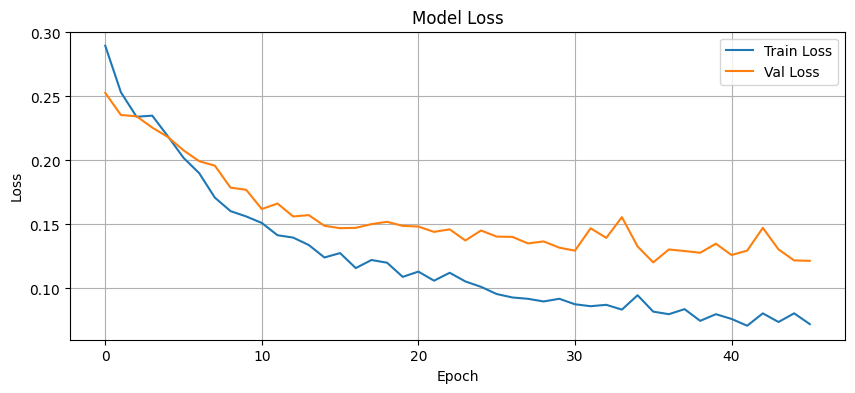

In [30]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Accuracy plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training(history)


##### Evaluate Model Performance (Confusion Matrix & Report)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


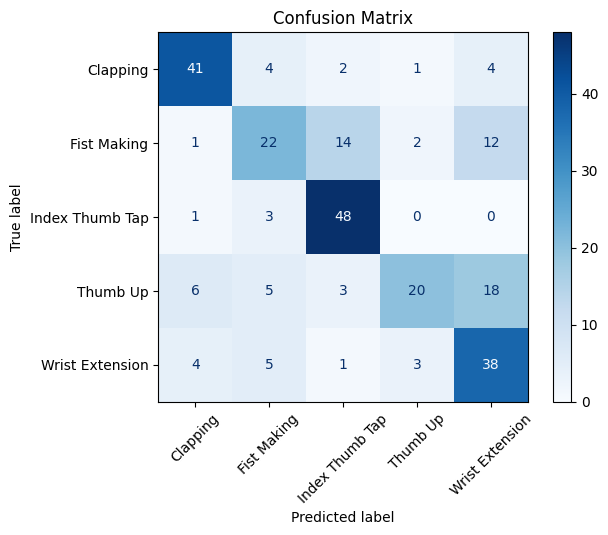

📊 Classification Report:

                 precision    recall  f1-score   support

       Clapping       0.77      0.79      0.78        52
    Fist Making       0.56      0.43      0.49        51
Index Thumb Tap       0.71      0.92      0.80        52
       Thumb Up       0.77      0.38      0.51        52
Wrist Extension       0.53      0.75      0.62        51

       accuracy                           0.66       258
      macro avg       0.67      0.65      0.64       258
   weighted avg       0.67      0.66      0.64       258



In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


#### Export the Trained TCN Model to .tflite

In [32]:
import tensorflow as tf

# Export full precision TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open("gesture_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Exported: gesture_model.tflite")


INFO:tensorflow:Assets written to: /tmp/tmpey99fjim/assets


INFO:tensorflow:Assets written to: /tmp/tmpey99fjim/assets


Saved artifact at '/tmp/tmpey99fjim'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 250), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139865590095440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590093904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590089488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590095056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590097936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590097744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096016: T

W0000 00:00:1744217078.189569 2158430 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744217078.189615 2158430 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-09 16:44:38.190290: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpey99fjim
2025-04-09 16:44:38.195431: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-09 16:44:38.195442: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpey99fjim
I0000 00:00:1744217078.247462 2158430 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-09 16:44:38.255456: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-09 16:44:38.517021: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpey99fjim
2025-04-09 16:44:38.595864: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

#### INT8 Quantization for Arduino Uno Compatibility

In [33]:
# Representative dataset function (simplified)
def representative_dataset():
    for i in range(100):
        yield [X_train[i:i+1].astype(np.float32)]

# Quantize model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_model = converter.convert()

# Save quantized model
with open("gesture_model_quant.tflite", "wb") as f:
    f.write(quantized_model)

print("✅ Exported: gesture_model_quant.tflite (INT8)")


INFO:tensorflow:Assets written to: /tmp/tmpypipwave/assets


INFO:tensorflow:Assets written to: /tmp/tmpypipwave/assets


Saved artifact at '/tmp/tmpypipwave'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 250), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139865590095440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590093904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590089488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590095056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590097936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590097744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139865590096016: T

/home/jupyter-st124872/.local/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1744217132.179205 2158430 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744217132.179223 2158430 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-09 16:45:32.179408: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpypipwave
2025-04-09 16:45:32.184191: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-09 16:45:32.184202: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpypipwave
2025-04-09 16:45:32.241867: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-09 16:45:32.504247: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /t

✅ Exported: gesture_model_quant.tflite (INT8)


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


#### Generate model.h for Arduino (from .tflite)

In [34]:
def generate_header_file(tflite_path, header_path):
    with open(tflite_path, "rb") as f:
        model_bytes = f.read()

    with open(header_path, "w") as f:
        f.write("const unsigned char model[] = {\n")
        for i, byte in enumerate(model_bytes):
            if i % 12 == 0:
                f.write("  ")
            f.write(f"0x{byte:02x}, ")
            if i % 12 == 11:
                f.write("\n")
        f.write("\n};\n")
        f.write(f"const unsigned int model_len = {len(model_bytes)};\n")

# Generate header
generate_header_file("gesture_model_quant.tflite", "model.h")
print("✅ model.h created for Arduino!")


✅ model.h created for Arduino!


##### Convert Real Sample to Arduino Format

In [35]:
import pandas as pd
import numpy as np

# ✏️ Change path to any subject folder
base_path = "HGAG-DATA1/HGAG-DATA1/Clapping/Subject_1/.csv"
length = 128  # Target sequence length

# 🚀 Load all 6 channels
def load_gesture_sample(folder):
    data = []
    for axis in ['accel_x_data', 'accel_y_data', 'accel_z_data', 
                 'gyro_x_data', 'gyro_y_data', 'gyro_z_data']:
        path = f"{folder}/{axis}.csv"
        values = pd.read_csv(path, header=None).values.flatten()
        values = values[:length] if len(values) >= length else np.pad(values, (0, length - len(values)))
        data.append(values)
    return np.stack(data, axis=1)  # shape: [128, 6]

# ✅ Example usage
sample = load_gesture_sample(base_path)

# ✨ Normalize similar to training (optional: match range to [0, 1])
sample_norm = (sample - np.mean(sample, axis=0)) / (np.std(sample, axis=0) + 1e-6)

# 📦 Convert to Arduino C array format
def to_arduino_array(arr, name="input_data"):
    print(f"float {name}[{arr.shape[0]}][{arr.shape[1]}] = {{")
    for row in arr:
        formatted = ", ".join([f"{v:.4f}" for v in row])
        print(f"  {{{formatted}}},")
    print("};")

to_arduino_array(sample_norm, "input_data")


float input_data[128][6] = {
  {0.0284, 0.0053, 0.0427, 0.0068, 0.0179, -0.0088},
  {1.6263, 0.9492, -1.3762, -0.4952, 0.2185, 0.1514},
  {-0.3773, -0.2344, 0.4029, 0.1342, -0.0331, -0.0495},
  {-0.3611, -0.2249, 0.3885, 0.1293, -0.0310, -0.0479},
  {-0.0729, -0.0545, 0.1326, 0.0385, 0.0051, -0.0190},
  {0.0125, -0.0042, 0.0567, 0.0119, 0.0160, -0.0104},
  {0.1893, 0.1003, -0.1002, -0.0439, 0.0380, 0.0073},
  {0.0541, 0.0204, 0.0199, -0.0011, 0.0212, -0.0062},
  {0.0838, 0.0380, -0.0065, -0.0108, 0.0248, -0.0034},
  {-0.0477, -0.0397, 0.1103, 0.0308, 0.0084, -0.0164},
  {0.0230, 0.0021, 0.0475, 0.0084, 0.0172, -0.0095},
  {-0.0078, -0.0161, 0.0748, 0.0181, 0.0133, -0.0124},
  {0.0521, 0.0192, 0.0216, -0.0005, 0.0209, -0.0065},
  {0.0386, 0.0114, 0.0336, 0.0033, 0.0191, -0.0077},
  {0.0366, 0.0100, 0.0354, 0.0046, 0.0191, -0.0080},
  {0.0340, 0.0087, 0.0378, 0.0046, 0.0184, -0.0083},
  {0.0120, -0.0046, 0.0572, 0.0125, 0.0160, -0.0104},
  {0.0358, 0.0097, 0.0362, 0.0039, 0.0186, -0.0082

##### Generate gesture_sample.cpp

In [2]:
import os
import pandas as pd
import numpy as np

# --- Configuration ---
base_dir = "HGAG-DATA1/HGAG-DATA1"
gestures = ["Clapping", "Fist Making", "Thumb Up", "Index Thumb Tap", "Wrist Extension"]
target_len = 128
output_file = "gesture_samples.cpp"
samples_per_gesture = 2  # adjust this if needed

# --- Normalize & Pad Function ---
def normalize_sequence(data):
    return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-6)

# --- Collect Samples ---
samples = []
labels = []

for gesture in gestures:
    gesture_dir = os.path.join(base_dir, gesture)
    subjects = [f for f in os.listdir(gesture_dir) if not f.startswith(".")]

    count = 0
    for subj in subjects:
        subj_path = os.path.join(gesture_dir, subj, ".csv")
        files = [f"{subj_path}/{axis}.csv" for axis in ['accel_x_data', 'accel_y_data', 'accel_z_data',
                                                         'gyro_x_data', 'gyro_y_data', 'gyro_z_data']]

        if all(os.path.exists(f) for f in files):
            data = []
            for f in files:
                col = pd.read_csv(f, header=None).values.flatten()
                col = col[:target_len] if len(col) >= target_len else np.pad(col, (0, target_len - len(col)))
                data.append(col)
            sample = np.stack(data, axis=1)  # shape: (128, 6)
            samples.append(normalize_sequence(sample))
            labels.append(gesture.replace(" ", "_"))
            count += 1
        if count >= samples_per_gesture:
            break

print(f"✅ Loaded {len(samples)} samples across {len(gestures)} gestures.")

# --- Write C++ File ---
with open(output_file, "w") as f:
    f.write(f"const int NUM_SAMPLES = {len(samples)};\n")
    f.write("const char* gesture_labels[] = {\n")
    for label in labels:
        f.write(f'  "{label}",\n')
    f.write("};\n\n")

    f.write(f"float input_data[{len(samples)}][{target_len}][6] = {{\n")
    for sample in samples:
        f.write("  {\n")
        for row in sample:
            f.write("    {" + ", ".join(f"{x:.6f}" for x in row) + "},\n")
        f.write("  },\n")
    f.write("};\n")

print(f"📁 Exported to {output_file}")



✅ Loaded 10 samples across 5 gestures.
📁 Exported to gesture_samples.cpp
